# Model Training Pipeline

Training models using the engineered features from Sprint 2 (02_Feature_Engineering.ipynb)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import pickle
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
# Handle categorical features
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# Import custom utilities
from src.utils import delete_keys_from_dict

plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

## 1. Load Engineered Features

Loading the features created in `02_Feature_Engineering.ipynb`

In [2]:
X_train_full = pd.read_csv('output/train_features_engineered.csv')
y_train_full = pd.read_csv('output/train_target.csv').squeeze()
X_test = pd.read_csv('output/test_features_engineered.csv')

print(f"  Training features: {X_train_full.shape}")
print(f"  Training target: {y_train_full.shape}")
print(f"  Test features: {X_test.shape}")
print(f"\n  Features: {X_train_full.shape[1]}")
print(f"  Training samples: {X_train_full.shape[0]:,}")
print(f"  Test samples: {X_test.shape[0]:,}")

  Training features: (100820, 45)
  Training target: (100820,)
  Test features: (44726, 46)

  Features: 45
  Training samples: 100,820
  Test samples: 44,726


## 2. Train/Validation Split

In [3]:
# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42
)

print("Data split:")
print(f"  Training: {X_train.shape[0]:,} samples")
print(f"  Validation: {X_val.shape[0]:,} samples")
print(f"  Test: {X_test.shape[0]:,} samples")

Data split:
  Training: 80,656 samples
  Validation: 20,164 samples
  Test: 44,726 samples


## 3. Preprocess Features

In [ ]:
# Identify feature types
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"Numeric features: {len(numeric_features)}")
print(f"Categorical features: {len(categorical_features)}")
if categorical_features:
    print(f"  Categorical: {categorical_features}")

# Create preprocessor
transformers = []
if numeric_features:
    transformers.append(('scaler', StandardScaler(), numeric_features))
if categorical_features:
    transformers.append(('encoder', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), categorical_features))

if transformers:
    preprocessor = ColumnTransformer(transformers=transformers, remainder='passthrough')
    
    # Fit and transform
    X_train_proc = preprocessor.fit_transform(X_train)
    X_val_proc = preprocessor.transform(X_val)
    X_test_proc = preprocessor.transform(X_test)
    
    print(f"\n✓ Preprocessing complete")
    print(f"  Final feature count: {X_train_proc.shape[1]}")
else:
    X_train_proc = X_train.values
    X_val_proc = X_val.values
    X_test_proc = X_test.values
    print("\n✓ No preprocessing needed")

Numeric features: 41
Categorical features: 3
  Categorical: ['performance_category', 'time_category', 'lexicon_category']

✓ Preprocessing complete
  Final feature count: 52


## 5. Hyperparameter Tuning

**Observations from baseline models:**
- RandomForest: High overfitting (train_rmse=56.29 vs val_rmse=92.75) → needs regularization
- XGBoost: Small train/val gap (train_rmse=94.55 vs val_rmse=98.22) → can train longer

**Strategy:**
- RandomForest: Reduce overfitting with max_depth, min_samples constraints, and max_features
- XGBoost: Increase capacity with more estimators, early stopping, and tuned learning rate


### 5.1 Random Forest Hyperparameter Tuning


In [5]:
from sklearn.model_selection import RandomizedSearchCV

# RandomForest hyperparameter search - focus on reducing overfitting
rf_param_dist = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [8, 10, 12, 15, 20],
    'min_samples_split': [5, 10, 15, 20],
    'min_samples_leaf': [2, 4, 6, 8],
    'max_features': ['sqrt', 0.4, 0.5, 0.6],
    'max_samples': [0.7, 0.8, 0.9]
}

print("Random Forest Hyperparameter Search")
print("=" * 60)
print("Running RandomizedSearchCV...")

rf_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42, n_jobs=-1),
    param_distributions=rf_param_dist,
    n_iter=50,  # Test 50 combinations
    cv=3,
    scoring='neg_mean_absolute_percentage_error',  # Use MAPE ⭐
    n_jobs=-1,
    random_state=42,
    verbose=1
)

rf_search.fit(X_train_proc, y_train)
rf_tuned = rf_search.best_estimator_

# Evaluate
y_pred_train_rf = rf_tuned.predict(X_train_proc)
y_pred_val_rf = rf_tuned.predict(X_val_proc)

train_mape_rf = np.mean(np.abs((y_train - y_pred_train_rf) / y_train)) * 100
val_mape_rf = np.mean(np.abs((y_val - y_pred_val_rf) / y_val)) * 100
train_rmse_rf = np.sqrt(mean_squared_error(y_train, y_pred_train_rf))
val_rmse_rf = np.sqrt(mean_squared_error(y_val, y_pred_val_rf))
val_r2_rf = r2_score(y_val, y_pred_val_rf)

print(f"\n{'='*60}")
print(f"BEST RANDOM FOREST")
print(f"{'='*60}")
print(f"\nMetrics:")
print(f"  Train MAPE: {train_mape_rf:.2f}% ⭐")
print(f"  Val MAPE:   {val_mape_rf:.2f}% ⭐")
print(f"  Val RMSE:   {val_rmse_rf:.2f}")
print(f"  Val R²:     {val_r2_rf:.4f}")
print(f"  Gap:        {val_rmse_rf - train_rmse_rf:.2f}")

rf_tuned_results = {
    'model': 'RandomForest_Tuned',
    'train_mape': train_mape_rf,
    'val_mape': val_mape_rf,
    'train_rmse': train_rmse_rf,
    'val_rmse': val_rmse_rf,
    'val_r2': val_r2_rf
}


Random Forest Hyperparameter Search
Running RandomizedSearchCV...
Fitting 3 folds for each of 50 candidates, totalling 150 fits

BEST RANDOM FOREST

Metrics:
  Train MAPE: 2.62% ⭐
  Val MAPE:   3.40% ⭐
  Val RMSE:   93.05
  Val R²:     0.8383
  Gap:        21.41


### 5.2 XGBoost Hyperparameter Tuning with Early Stopping


In [6]:
# XGBoost hyperparameter search with early stopping
xgb_param_dist = {
    'n_estimators': [300, 500, 800, 1000],
    'max_depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.3],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [1, 1.5, 2]
}

print("XGBoost Hyperparameter Search")
print("=" * 60)
print("Running RandomizedSearchCV with early stopping...")

xgb_search = RandomizedSearchCV(
    estimator=xgb.XGBRegressor(
        random_state=42, n_jobs=-1,
        early_stopping_rounds=50, eval_metric='rmse'
    ),
    param_distributions=xgb_param_dist,
    n_iter=50,  # Test 50 combinations
    cv=3,
    scoring='neg_mean_absolute_percentage_error',  # Use MAPE ⭐
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Fit with validation set for early stopping
xgb_search.fit(
    X_train_proc, y_train,
    eval_set=[(X_val_proc, y_val)],
    verbose=False
)

xgb_tuned = xgb_search.best_estimator_

# Evaluate
y_pred_train_xgb = xgb_tuned.predict(X_train_proc)
y_pred_val_xgb = xgb_tuned.predict(X_val_proc)

train_mape_xgb = np.mean(np.abs((y_train - y_pred_train_xgb) / y_train)) * 100
val_mape_xgb = np.mean(np.abs((y_val - y_pred_val_xgb) / y_val)) * 100
train_rmse_xgb = np.sqrt(mean_squared_error(y_train, y_pred_train_xgb))
val_rmse_xgb = np.sqrt(mean_squared_error(y_val, y_pred_val_xgb))
val_r2_xgb = r2_score(y_val, y_pred_val_xgb)

print(f"\n{'='*60}")
print(f"BEST XGBOOST")
print(f"{'='*60}")
print(f"\nMetrics:")
print(f"  Train MAPE: {train_mape_xgb:.2f}% ⭐")
print(f"  Val MAPE:   {val_mape_xgb:.2f}% ⭐")
print(f"  Val RMSE:   {val_rmse_xgb:.2f}")
print(f"  Val R²:     {val_r2_xgb:.4f}")
print(f"  Gap:        {val_rmse_xgb - train_rmse_xgb:.2f}")
print(f"  Best iter:  {xgb_tuned.best_iteration if hasattr(xgb_tuned, 'best_iteration') else 'N/A'}")

xgb_tuned_results = {
    'model': 'XGBoost_Tuned',
    'train_mape': train_mape_xgb,
    'val_mape': val_mape_xgb,
    'train_rmse': train_rmse_xgb,
    'val_rmse': val_rmse_xgb,
    'val_r2': val_r2_xgb
}


XGBoost Hyperparameter Search
Running RandomizedSearchCV with early stopping...
Fitting 3 folds for each of 50 candidates, totalling 150 fits



BEST XGBOOST

Metrics:
  Train MAPE: 2.71% ⭐
  Val MAPE:   3.31% ⭐
  Val RMSE:   90.58
  Val R²:     0.8468
  Gap:        17.20
  Best iter:  173


### 5.3 Baseline vs Tuned Model Comparison


In [7]:
# Compare tuned models - PRIMARY METRIC: MAPE
tuned_comparison = pd.DataFrame([rf_tuned_results, xgb_tuned_results])
tuned_comparison = tuned_comparison.sort_values('val_mape')  # Sort by MAPE (primary metric)

# Calculate overfitting gap
tuned_comparison['overfitting_gap'] = tuned_comparison['val_rmse'] - tuned_comparison['train_rmse']

print("\n" + "="*80)
print("TUNED MODELS COMPARISON (Sorted by MAPE ⭐)")
print("="*80)
print(tuned_comparison[['model', 'val_mape', 'val_rmse', 'val_r2', 'overfitting_gap']].to_string(index=False))

# Best model
best_model_row = tuned_comparison.iloc[0]
print(f"\n{'='*80}")
print(f"BEST MODEL (by MAPE): {best_model_row['model']}")
print(f"{'='*80}")
print(f"  Validation MAPE: {best_model_row['val_mape']:.2f}%  ⭐ PRIMARY METRIC")
print(f"  Validation RMSE: {best_model_row['val_rmse']:.2f}")
print(f"  Validation R²:   {best_model_row['val_r2']:.4f}")
print(f"  Overfitting Gap: {best_model_row['overfitting_gap']:.2f}")



TUNED MODELS COMPARISON (Sorted by MAPE ⭐)
             model  val_mape  val_rmse   val_r2  overfitting_gap
     XGBoost_Tuned  3.307853 90.582285 0.846801        17.196163
RandomForest_Tuned  3.395764 93.048116 0.838347        21.411875

BEST MODEL (by MAPE): XGBoost_Tuned
  Validation MAPE: 3.31%  ⭐ PRIMARY METRIC
  Validation RMSE: 90.58
  Validation R²:   0.8468
  Overfitting Gap: 17.20


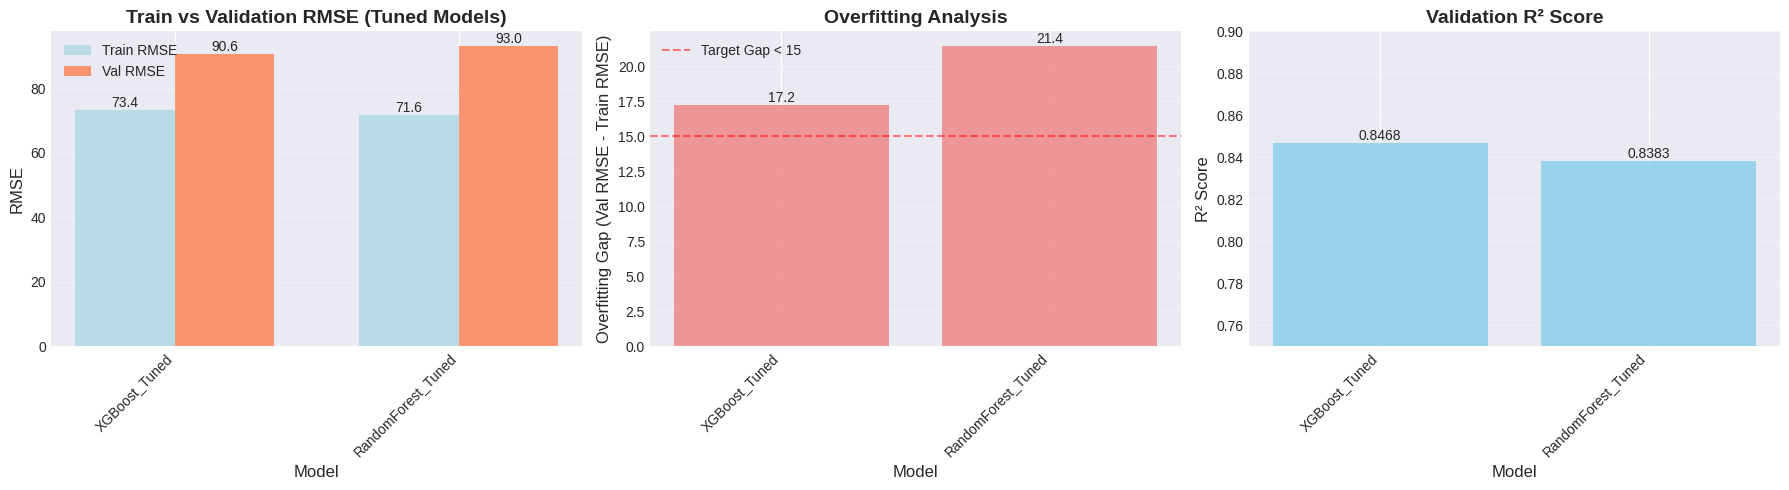


✓ Visualization saved to output/tuned_models_comparison.png


In [8]:
# Visualize tuned model comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. RMSE comparison
models = tuned_comparison['model'].values
train_rmse_vals = tuned_comparison['train_rmse'].values
val_rmse_vals = tuned_comparison['val_rmse'].values

x = np.arange(len(models))
width = 0.35

bars1 = axes[0].bar(x - width/2, train_rmse_vals, width, label='Train RMSE', alpha=0.8, color='lightblue')
bars2 = axes[0].bar(x + width/2, val_rmse_vals, width, label='Val RMSE', alpha=0.8, color='coral')
axes[0].set_xlabel('Model', fontsize=12)
axes[0].set_ylabel('RMSE', fontsize=12)
axes[0].set_title('Train vs Validation RMSE (Tuned Models)', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(models, rotation=45, ha='right')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1f}',
                    ha='center', va='bottom', fontsize=10)

# 2. Overfitting gap
overfitting_gaps = tuned_comparison['overfitting_gap'].values
colors = ['lightcoral' if gap > 15 else 'lightgreen' for gap in overfitting_gaps]
bars = axes[1].bar(models, overfitting_gaps, alpha=0.8, color=colors)
axes[1].set_xlabel('Model', fontsize=12)
axes[1].set_ylabel('Overfitting Gap (Val RMSE - Train RMSE)', fontsize=12)
axes[1].set_title('Overfitting Analysis', fontsize=14, fontweight='bold')
axes[1].set_xticklabels(models, rotation=45, ha='right')
axes[1].axhline(y=15, color='red', linestyle='--', alpha=0.5, label='Target Gap < 15')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

# Add value labels
for bar in bars:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}',
                ha='center', va='bottom', fontsize=10)

# 3. R² Score
val_r2_vals = tuned_comparison['val_r2'].values
bars = axes[2].bar(models, val_r2_vals, alpha=0.8, color='skyblue')
axes[2].set_xlabel('Model', fontsize=12)
axes[2].set_ylabel('R² Score', fontsize=12)
axes[2].set_title('Validation R² Score', fontsize=14, fontweight='bold')
axes[2].set_xticklabels(models, rotation=45, ha='right')
axes[2].set_ylim([0.75, 0.90])
axes[2].grid(True, alpha=0.3, axis='y')

# Add value labels
for bar in bars:
    height = bar.get_height()
    axes[2].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('output/tuned_models_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Visualization saved to output/tuned_models_comparison.png")


### 5.4 Feature Pruning Based on Importance


In [9]:
# Initialize pruning variables (in case feature pruning is skipped)
pruning_df = pd.DataFrame()
best_rf_pruned_idx = 0
best_xgb_pruned_idx = 0
top_features_sorted = []


In [10]:
# Extract feature importance from best tuned models
print("Analyzing Feature Importance for Pruning")
print("=" * 60)

# Get feature importances from both tuned models
rf_importances = rf_tuned.feature_importances_
xgb_importances = xgb_tuned.feature_importances_

# Average importance across models
avg_importances = (rf_importances + xgb_importances) / 2

# Create feature importance dataframe
try:
    feature_names_list = []
    if 'scaler' in preprocessor.named_transformers_:
        feature_names_list.extend(numeric_features)
    if 'encoder' in preprocessor.named_transformers_:
        ohe = preprocessor.named_transformers_['encoder']
        cat_names = ohe.get_feature_names_out(categorical_features).tolist()
        feature_names_list.extend(cat_names)
    
    if len(feature_names_list) != len(avg_importances):
        feature_names_list = [f'feature_{i}' for i in range(len(avg_importances))]
except:
    feature_names_list = [f'feature_{i}' for i in range(len(avg_importances))]

importance_df = pd.DataFrame({
    'feature': feature_names_list,
    'rf_importance': rf_importances,
    'xgb_importance': xgb_importances,
    'avg_importance': avg_importances
}).sort_values('avg_importance', ascending=False)

print(f"\nTotal features: {len(importance_df)}")
print(f"\nTop 15 Most Important Features:")
print(importance_df.head(15)[['feature', 'avg_importance']].to_string(index=False))

print(f"\nBottom 10 Least Important Features:")
print(importance_df.tail(10)[['feature', 'avg_importance']].to_string(index=False))

# Calculate cumulative importance
importance_df['cumulative_importance'] = importance_df['avg_importance'].cumsum() / importance_df['avg_importance'].sum()

# Find how many features are needed for 95%, 98%, 99% of importance
for threshold in [0.95, 0.98, 0.99]:
    n_features = (importance_df['cumulative_importance'] <= threshold).sum() + 1
    print(f"\nFeatures needed for {threshold*100:.0f}% importance: {n_features} / {len(importance_df)}")


Analyzing Feature Importance for Pruning

Total features: 52

Top 15 Most Important Features:
   feature  avg_importance
feature_48        0.480913
feature_49        0.135416
 feature_2        0.052718
feature_11        0.052705
feature_39        0.030632
feature_16        0.029276
feature_51        0.028761
feature_32        0.026648
feature_31        0.022848
feature_27        0.020359
 feature_9        0.017994
feature_25        0.015354
 feature_7        0.013962
feature_38        0.006565
 feature_1        0.004654

Bottom 10 Least Important Features:
   feature  avg_importance
feature_44        0.000212
feature_19        0.000190
feature_43        0.000177
feature_42        0.000115
 feature_6        0.000089
 feature_5        0.000079
feature_18        0.000065
feature_24        0.000057
feature_41        0.000016
feature_15        0.000000

Features needed for 95% importance: 18 / 52

Features needed for 98% importance: 28 / 52

Features needed for 99% importance: 33 / 52


In [ ]:
# Test models with different numbers of features
print("\n" + "=" * 60)
print("Testing Feature Pruning")
print("=" * 60)
print("Training models with progressively fewer features...\n")

# Get indices of top features
top_features_sorted = importance_df['feature'].values

# Test different feature counts
feature_counts = [
    len(importance_df),  # All features
    40,  # ~75% of features
    30,  # ~60% of features
    20,  # ~40% of features
    15,  # ~30% of features
]

pruning_results = []

for n_features in feature_counts:
    if n_features > len(top_features_sorted):
        continue
        
    # Get top N features
    selected_features = top_features_sorted[:n_features]
    
    # Find column indices in processed data
    feature_indices = [i for i, feat in enumerate(feature_names_list) if feat in selected_features]
    
    # Create pruned datasets
    X_train_pruned = X_train_proc[:, feature_indices]
    X_val_pruned = X_val_proc[:, feature_indices]
    
    # Train RandomForest with pruned features
    rf_params = delete_keys_from_dict(rf_tuned.get_params(), ['random_state', 'n_jobs'])
    rf_pruned = RandomForestRegressor(random_state=42, n_jobs=-1, **rf_params)
    rf_pruned.fit(X_train_pruned, y_train)
    
    train_pred_rf = rf_pruned.predict(X_train_pruned)
    val_pred_rf = rf_pruned.predict(X_val_pruned)
    
    train_rmse_rf = np.sqrt(mean_squared_error(y_train, train_pred_rf))
    val_rmse_rf = np.sqrt(mean_squared_error(y_val, val_pred_rf))
    val_r2_rf = r2_score(y_val, val_pred_rf)
    val_mape_rf = np.mean(np.abs((y_val - val_pred_rf) / y_val)) * 100
    
    # Train XGBoost with pruned features (using tuned hyperparameters)
    xgb_params = delete_keys_from_dict(xgb_tuned.get_params(), 
                                       ['early_stopping_rounds', 'eval_metric', 'n_jobs', 'random_state'])
    xgb_pruned = xgb.XGBRegressor(
        random_state=42,
        n_jobs=-1,
        early_stopping_rounds=50,
        eval_metric='rmse',
        **xgb_params
    )
    xgb_pruned.fit(
        X_train_pruned, y_train,
        eval_set=[(X_val_pruned, y_val)],
        verbose=False
    )
    
    train_pred_xgb = xgb_pruned.predict(X_train_pruned)
    val_pred_xgb = xgb_pruned.predict(X_val_pruned)
    
    train_rmse_xgb = np.sqrt(mean_squared_error(y_train, train_pred_xgb))
    val_rmse_xgb = np.sqrt(mean_squared_error(y_val, val_pred_xgb))
    val_r2_xgb = r2_score(y_val, val_pred_xgb)
    val_mape_xgb = np.mean(np.abs((y_val - val_pred_xgb) / y_val)) * 100
    
    pruning_results.append({
        'n_features': n_features,
        'rf_train_rmse': train_rmse_rf,
        'rf_val_rmse': val_rmse_rf,
        'rf_val_r2': val_r2_rf,
        'rf_val_mape': val_mape_rf,
        'rf_gap': val_rmse_rf - train_rmse_rf,
        'xgb_train_rmse': train_rmse_xgb,
        'xgb_val_rmse': val_rmse_xgb,
        'xgb_val_r2': val_r2_xgb,
        'xgb_val_mape': val_mape_xgb,
        'xgb_gap': val_rmse_xgb - train_rmse_xgb
    })
    
    print(f"{n_features:3d} features | RF MAPE: {val_mape_rf:.2f}% ⭐ | XGB MAPE: {val_mape_xgb:.2f}% ⭐")

pruning_df = pd.DataFrame(pruning_results)

# Find best configuration by MAPE (primary metric)
best_rf_pruned_idx = pruning_df['rf_val_mape'].idxmin()
best_xgb_pruned_idx = pruning_df['xgb_val_mape'].idxmin()

print(f"\n{'='*60}")
print(f"Best RandomForest (by MAPE ⭐):")
print(f"  Features: {pruning_df.iloc[best_rf_pruned_idx]['n_features']:.0f}")
print(f"  MAPE: {pruning_df.iloc[best_rf_pruned_idx]['rf_val_mape']:.2f}% ⭐")
print(f"  RMSE: {pruning_df.iloc[best_rf_pruned_idx]['rf_val_rmse']:.2f}")

print(f"\nBest XGBoost (by MAPE ⭐):")
print(f"  Features: {pruning_df.iloc[best_xgb_pruned_idx]['n_features']:.0f}")
print(f"  MAPE: {pruning_df.iloc[best_xgb_pruned_idx]['xgb_val_mape']:.2f}% ⭐")
print(f"  RMSE: {pruning_df.iloc[best_xgb_pruned_idx]['xgb_val_rmse']:.2f}")



Testing Feature Pruning
Training models with progressively fewer features...



 52 features | RF: MAPE=3.40% ⭐ RMSE=93.05 | XGB: MAPE=3.31% ⭐ RMSE=90.58
 40 features | RF: MAPE=3.40% ⭐ RMSE=93.24 | XGB: MAPE=3.30% ⭐ RMSE=90.72
 30 features | RF: MAPE=3.41% ⭐ RMSE=93.29 | XGB: MAPE=3.32% ⭐ RMSE=90.99
 20 features | RF: MAPE=3.39% ⭐ RMSE=92.91 | XGB: MAPE=3.30% ⭐ RMSE=90.54
 15 features | RF: MAPE=3.39% ⭐ RMSE=93.00 | XGB: MAPE=3.31% ⭐ RMSE=90.66

Best RandomForest with Feature Pruning (by MAPE ⭐):
  Features: 20
  Val MAPE: 3.39%  ⭐
  Val RMSE: 92.91
  Val R²: 0.8388

Best XGBoost with Feature Pruning (by MAPE ⭐):
  Features: 20
  Val MAPE: 3.30%  ⭐
  Val RMSE: 90.54
  Val R²: 0.8469


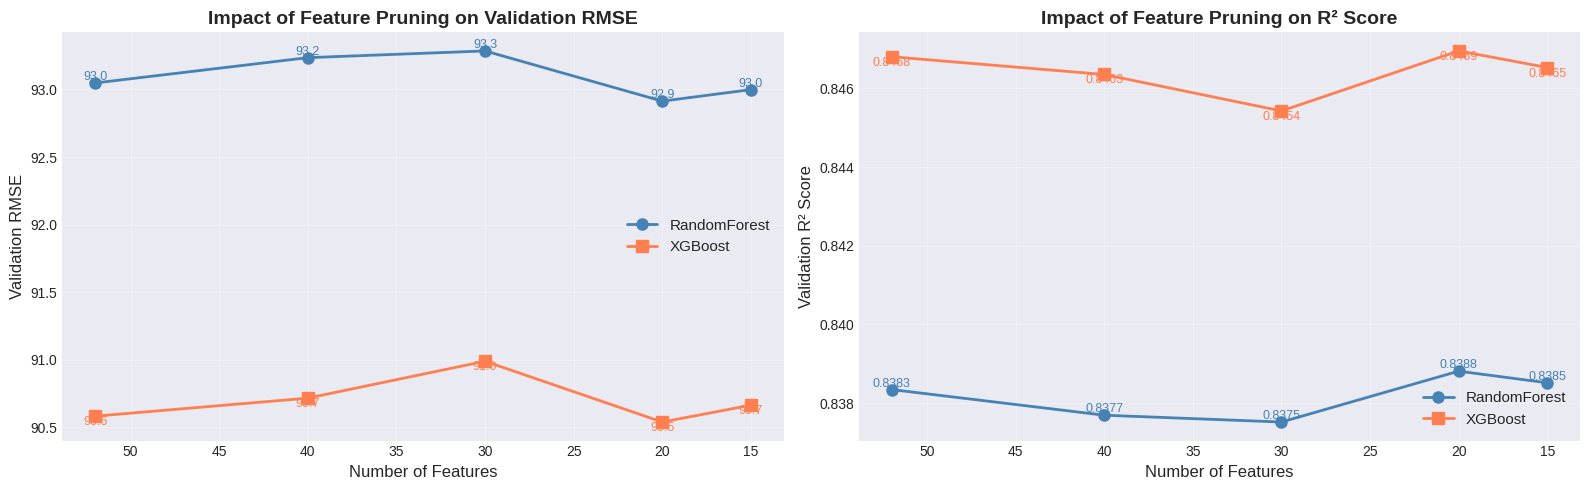


✓ Visualization saved to output/feature_pruning_analysis.png


In [16]:
# Visualize feature pruning impact
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# 1. Validation RMSE vs Number of Features
axes[0].plot(pruning_df['n_features'], pruning_df['rf_val_rmse'], 
             marker='o', linewidth=2, markersize=8, label='RandomForest', color='steelblue')
axes[0].plot(pruning_df['n_features'], pruning_df['xgb_val_rmse'], 
             marker='s', linewidth=2, markersize=8, label='XGBoost', color='coral')
axes[0].set_xlabel('Number of Features', fontsize=12)
axes[0].set_ylabel('Validation RMSE', fontsize=12)
axes[0].set_title('Impact of Feature Pruning on Validation RMSE', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)
axes[0].invert_xaxis()  # Invert so it goes from all features to fewer

# Add value labels
for i, row in pruning_df.iterrows():
    axes[0].text(row['n_features'], row['rf_val_rmse'], f"{row['rf_val_rmse']:.1f}", 
                ha='center', va='bottom', fontsize=9, color='steelblue')
    axes[0].text(row['n_features'], row['xgb_val_rmse'], f"{row['xgb_val_rmse']:.1f}", 
                ha='center', va='top', fontsize=9, color='coral')

# 2. R² Score vs Number of Features
axes[1].plot(pruning_df['n_features'], pruning_df['rf_val_r2'], 
             marker='o', linewidth=2, markersize=8, label='RandomForest', color='steelblue')
axes[1].plot(pruning_df['n_features'], pruning_df['xgb_val_r2'], 
             marker='s', linewidth=2, markersize=8, label='XGBoost', color='coral')
axes[1].set_xlabel('Number of Features', fontsize=12)
axes[1].set_ylabel('Validation R² Score', fontsize=12)
axes[1].set_title('Impact of Feature Pruning on R² Score', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)
axes[1].invert_xaxis()

# Add value labels
for i, row in pruning_df.iterrows():
    axes[1].text(row['n_features'], row['rf_val_r2'], f"{row['rf_val_r2']:.4f}", 
                ha='center', va='bottom', fontsize=9, color='steelblue')
    axes[1].text(row['n_features'], row['xgb_val_r2'], f"{row['xgb_val_r2']:.4f}", 
                ha='center', va='top', fontsize=9, color='coral')

plt.tight_layout()
plt.savefig('output/feature_pruning_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Visualization saved to output/feature_pruning_analysis.png")


## 6. Final Model Selection and Predictions


In [ ]:
# Select best model based on MAPE (PRIMARY METRIC) ⭐
print("Final Model Selection")
print("=" * 60)

# Compare tuned models (and pruned if available)
best_rf_mape = rf_tuned_results['val_mape']
best_xgb_mape = xgb_tuned_results['val_mape']
rf_features = list(range(len(feature_names_list)))
xgb_features = list(range(len(feature_names_list)))

# Check if pruning improved results
if not pruning_df.empty:
    if pruning_df.iloc[best_rf_pruned_idx]['rf_val_mape'] < best_rf_mape:
        best_rf_mape = pruning_df.iloc[best_rf_pruned_idx]['rf_val_mape']
        n_feat = int(pruning_df.iloc[best_rf_pruned_idx]['n_features'])
        rf_features = [i for i, feat in enumerate(feature_names_list) if feat in top_features_sorted[:n_feat]]
        print(f"✓ Using pruned RF ({n_feat} features, MAPE: {best_rf_mape:.2f}%)")
    
    if pruning_df.iloc[best_xgb_pruned_idx]['xgb_val_mape'] < best_xgb_mape:
        best_xgb_mape = pruning_df.iloc[best_xgb_pruned_idx]['xgb_val_mape']
        n_feat = int(pruning_df.iloc[best_xgb_pruned_idx]['n_features'])
        xgb_features = [i for i, feat in enumerate(feature_names_list) if feat in top_features_sorted[:n_feat]]
        print(f"✓ Using pruned XGB ({n_feat} features, MAPE: {best_xgb_mape:.2f}%)")

# Select best model
if best_rf_mape < best_xgb_mape:
    model_type = 'RandomForest'
    rf_params = delete_keys_from_dict(rf_tuned.get_params(), ['random_state', 'n_jobs'])
    final_model = RandomForestRegressor(random_state=42, n_jobs=-1, **rf_params)
    feature_indices = rf_features
    best_mape = best_rf_mape
else:
    model_type = 'XGBoost'
    xgb_params = delete_keys_from_dict(xgb_tuned.get_params(), 
                                       ['early_stopping_rounds', 'eval_metric', 'n_jobs', 'random_state'])
    final_model = xgb.XGBRegressor(random_state=42, n_jobs=-1, early_stopping_rounds=50, 
                                    eval_metric='rmse', **xgb_params)
    feature_indices = xgb_features
    best_mape = best_xgb_mape

print(f"\nBest Model: {model_type}")
print(f"  MAPE: {best_mape:.2f}% ⭐")
print(f"  Features: {len(feature_indices)}")

# Retrain on full training set
X_full_proc = preprocessor.transform(X_train_full)[:, feature_indices]

if model_type == 'XGBoost':
    X_tr, X_vl, y_tr, y_vl = train_test_split(X_full_proc, y_train_full, test_size=0.1, random_state=42)
    final_model.fit(X_tr, y_tr, eval_set=[(X_vl, y_vl)], verbose=False)
else:
    final_model.fit(X_full_proc, y_train_full)

# Generate test predictions
test_predictions = final_model.predict(X_test_proc[:, feature_indices])
test_predictions = np.clip(test_predictions, 500, 3000)

print(f"✓ Trained and generated {len(test_predictions):,} predictions")


Final Model Selection
✓ Using pruned RF (20 features, MAPE: 3.39%)
✓ Using pruned XGB (20 features, MAPE: 3.30%)

Best Model: XGBoost
  MAPE: 3.30% ⭐
  Features: 20


✓ Trained and generated 44,726 predictions


In [21]:
# Save the best model
model_filename = f'output/best_model_{model_type.lower()}_tuned.pkl'
with open(model_filename, 'wb') as f:
    pickle.dump(final_model, f)
print(f"\n✓ Model saved to {model_filename}")

# Save the preprocessor
preprocessor_filename = 'output/preprocessor.pkl'
with open(preprocessor_filename, 'wb') as f:
    pickle.dump(preprocessor, f)
print(f"✓ Preprocessor saved to {preprocessor_filename}")

# Save feature indices used (important for pruned models)
feature_info = {
    'feature_indices': feature_indices,
    'selected_features': [feature_names_list[i] for i in feature_indices]
}
with open('output/selected_features.pkl', 'wb') as f:
    pickle.dump(feature_info, f)
print(f"✓ Feature information saved to output/selected_features.pkl")

# Save predictions
predictions_df = pd.DataFrame({
    'rating': test_predictions
})
predictions_df.to_csv('output/test_predictions_final.csv', index=False)
print(f"✓ Predictions saved to output/test_predictions_final.csv")

# Save model comparison
tuned_comparison.to_csv('output/model_comparison_tuned.csv', index=False)
print(f"✓ Model comparison saved to output/model_comparison_tuned.csv")

# Save pruning results if available
if not pruning_df.empty:
    pruning_df.to_csv('output/feature_pruning_results.csv', index=False)
    print(f"✓ Feature pruning results saved to output/feature_pruning_results.csv")

print(f"\n{'='*60}")
print(f"TRAINING COMPLETE!")
print(f"{'='*60}")
print(f"Model Type: {model_type}")
print(f"Features Used: {len(feature_indices)}")
print(f"Final MAPE: {best_mape:.2f}% ⭐")



✓ Model saved to output/best_model_xgboost_tuned.pkl
✓ Preprocessor saved to output/preprocessor.pkl
✓ Feature information saved to output/selected_features.pkl
✓ Predictions saved to output/test_predictions_final.csv
✓ Model comparison saved to output/model_comparison_tuned.csv
✓ Feature pruning results saved to output/feature_pruning_results.csv

TRAINING COMPLETE!
Model Type: XGBoost
Features Used: 20
Final MAPE: 3.30% ⭐
